In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from ingestion import read_asec_data, read_asec_dictionary

Number of records:
* Household: 94,097
* Family: 80,610
* Person: 185,487

In [2]:
# I am not at all sure if it's more appropriate to do this at a personal level or household level;
# I am guessing personal, since that is how federal income tax is administered, so we're going with
# that for now.

# We are also using the taxable income amount for the time being, again I don't know if this is necessarily
# the right approach, but it seems plausible as a first pass.

# TODO: Read up more on the various income metrics

records = read_asec_data('data/asec2016_pubuse_v2.dat', 'data/asec2016_dd.txt', 'person', ['MARSUPWT', 'TAX_INC', 'WSAL_VAL'])
person_df = pd.DataFrame(records)
person_df.columns = [x.lower() for x in person_df.columns]
person_df['marsupwt'] = person_df['marsupwt'].astype(float) / 100
person_df['tax_inc'] = person_df['tax_inc'].astype(int)
person_df['wsal_val'] = person_df['wsal_val'].astype(int)
person_df = person_df.sort_values('tax_inc')

In [3]:
person_df.head()

,marsupwt,tax_inc,wsal_val
0,1132.05,0,0
110808,730.13,0,2000
110810,647.50,0,61000
110811,654.41,0,0
110812,624.26,0,0


In [4]:
print('No income: {}'.format(len(person_df[person_df['tax_inc'] > 0])))
print('Total: {}'.format(len(person_df)))
print('Fraction: {}'.format(float(len(person_df[person_df['tax_inc'] > 0])) / len(person_df)))

No income: 63057
Total: 185487
Fraction: 0.339953743389


In [5]:
person_df.loc[person_df['wsal_val'] == 0, 'marsupwt'].sum()/person_df['marsupwt'].sum()

0.5166817057846174

In [6]:
quantiled = person_df.copy()
quantiled['samp_prob'] = quantiled['marsupwt'] / quantiled['marsupwt'].sum()
quantiled = quantiled.sort_values('wsal_val')
quantiled['wsal_quantile'] = np.cumsum(quantiled['samp_prob'])
quantiled[quantiled['wsal_quantile'] >= .99].head()

,marsupwt,tax_inc,wsal_val,samp_prob,wsal_quantile
122330,3602.74,198446,190000,0.000011,0.990009
37286,3507.19,179917,190000,0.000011,0.990020
19910,1457.42,169431,190000,0.000005,0.990025
183945,625.82,272201,190000,0.000002,0.990027
111311,854.69,169480,190000,0.000003,0.990029


So if you earn more than \$190k, you're in the top 1%, according to this. Let's try this with the population of people who had wages more than $0:

In [7]:
earners = person_df[person_df['wsal_val'] > 0]
earners['samp_prob'] = earners['marsupwt'] / earners['marsupwt'].sum()
earners = earners.sort_values('wsal_val')
earners['wsal_quantile'] = np.cumsum(earners['samp_prob'])
earners[earners['wsal_quantile'] >= .99].head()

/home/vagrant/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,marsupwt,tax_inc,wsal_val,samp_prob,wsal_quantile
16058,3810.52,243737,250000,0.000025,0.990015
59763,1173.39,0,250000,0.000008,0.990023
179026,1431.85,240635,250000,0.000009,0.990032
81896,1730.39,220022,250000,0.000011,0.990044
148580,3230.13,0,250000,0.000021,0.990065


So earning \$250k puts you in the top 1% of people who earned wages last year.

Let's try this with households, to see if we can match that Excel worksheet from the census website:

In [8]:
records = read_asec_data('data/asec2016_pubuse_v2.dat', 'data/asec2016_dd.txt', 'household', ['HSUP_WGT', 'HTOTVAL'])
hh_df = pd.DataFrame(records)
hh_df.columns = [x.lower() for x in hh_df.columns]
hh_df['hsup_wgt'] = hh_df['hsup_wgt'].astype(float) / 100
hh_df['htotval'] = hh_df['htotval'].astype(int)
hh_df['samp_prob'] = hh_df['hsup_wgt']/hh_df['hsup_wgt'].sum()
hh_df = hh_df.sort_values('htotval')
hh_df['htot_quantile'] = np.cumsum(hh_df['samp_prob'])
hh_df[abs(hh_df['htotval'] - 250000) == min(abs(hh_df['htotval']-250000))]

,hsup_wgt,htotval,samp_prob,htot_quantile
5733,943.88,250000,0.000007,0.966734
46214,1915.13,250000,0.000015,0.966749
59628,1271.44,250000,0.000010,0.966759
74091,171.53,250000,0.000001,0.966760
86342,1497.28,250000,0.000012,0.966772
68576,1536.90,250000,0.000012,0.966784
8494,3274.97,250000,0.000026,0.966810
61090,895.70,250000,0.000007,0.966817
65472,4077.60,250000,0.000032,0.966850


This is exactly what the Excel spreadsheet gives, to within .0005%! WE DID IT!!!!!!!

So now let's plot the distribution of personal income in the US, both for people who earned wages and people who did not. We'll just start from scratch:

In [9]:
person_records = read_asec_data('data/asec2016_pubuse_v2.dat', 'data/asec2016_dd.txt', 'person',
                                ['MARSUPWT', 'TAX_INC', 'WSAL_VAL', 'FEDTAX_BC', 'FEDTAX_AC'])
person_df = pd.DataFrame(person_records)
person_df.columns = [x.lower() for x in person_df.columns]
person_df['marsupwt'] = person_df['marsupwt'].astype(float) / 100
person_df['tax_inc'] = person_df['tax_inc'].astype(int)
person_df['wsal_val'] = person_df['wsal_val'].astype(int)
person_df['fedtax_bc'] = person_df['fedtax_bc'].astype(int)
person_df['fedtax_ac'] = person_df['fedtax_ac'].astype(int)

In [10]:
def add_quantiles(df, metric, weight='marsupwt'):
    df = df.sort_values(metric)
    samp_prob = df[weight]/df[weight].sum()
    df['{}_quantile'.format(metric)] = np.cumsum(samp_prob) / sum(samp_prob)
    return df

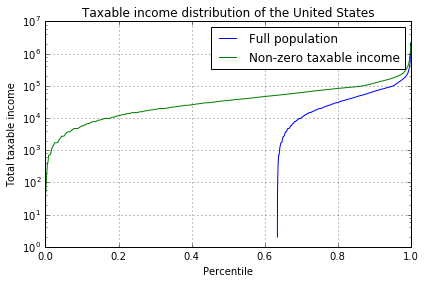

In [11]:
metric = 'tax_inc'
full_population = add_quantiles(person_df, metric)
person_df = add_quantiles(person_df, metric)
earners_only = add_quantiles(person_df[person_df[metric] > 0], metric)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(full_population['{}_quantile'.format(metric)], full_population[metric], label='Full population')
ax.semilogy(earners_only['{}_quantile'.format(metric)], earners_only[metric], label='Non-zero taxable income')
ax.grid(True)
ax.set_ylabel('Total taxable income')
ax.set_xlabel('Percentile')
ax.set_title('Taxable income distribution of the United States')
ax.legend()
fig.tight_layout()

Let's try the PDF of these:

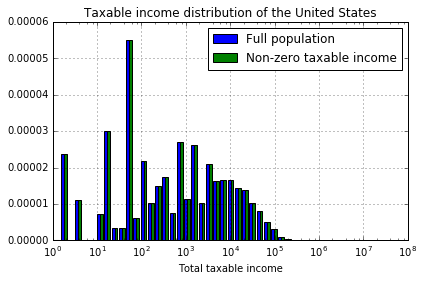

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist([full_population[metric], earners_only[metric]], np.logspace(0, 8, num=50), normed=1,
        histtype='bar', label=['Full population', 'Non-zero taxable income'])
ax.grid(True)
ax.set_xscale('log')
ax.set_xlabel('Total taxable income')
ax.set_title('Taxable income distribution of the United States')
ax.legend()
fig.tight_layout()

The logspace makes the distributions the same, since you can't show zero, so let's just try a linear scale:

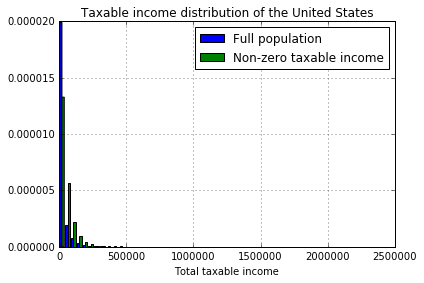

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist([full_population[metric], earners_only[metric]], bins=50, normed=1,
        histtype='bar', label=['Full population', 'Non-zero taxable income'])
ax.grid(True)
ax.set_xlabel('Total taxable income')
ax.set_title('Taxable income distribution of the United States')
ax.legend()
fig.tight_layout()

Let's try looking at tax liability, since that's ultimately what we care about:

In [14]:
metric = 'fedtax_bc'
person_df = add_quantiles(person_df, metric)
earners_only = add_quantiles(earners_only, metric)

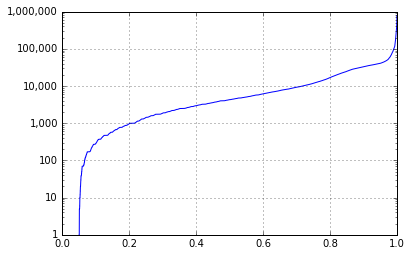

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(earners_only['{}_quantile'.format(metric)], earners_only[metric])
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.grid(True)

In [16]:
min(earners_only.loc[earners_only[metric]>0, '{}_quantile'.format(metric)])

0.051262413625389823

In [17]:
earners_only.loc[earners_only[metric]>0].sort_values(metric).head()

,fedtax_ac,fedtax_bc,marsupwt,tax_inc,wsal_val,tax_inc_quantile,fedtax_bc_quantile
10875,1,1,1830.33,14,4000,0.000082,0.051262
105909,1,1,863.41,14,0,0.000067,0.051270
174222,1,1,1424.41,11,0,0.000059,0.051282
95864,-344,1,3474.86,10,10300,0.000047,0.051312
27807,2,2,1979.79,20,0,0.000205,0.051486
